In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


def import_data(name):
    #Data Path has to be set as per the file location in your system
    data_path = ['dados']
    #The filepath is dependent on the data_path set in the previous cell 
    filepath = os.sep.join(data_path + [name])
    return  pd.read_csv(filepath, sep=',')

In [2]:
def correlation(data):
    feature_cols = data.columns[:-1]
    corr_values = data[feature_cols].corr()
    tril_index = np.tril_indices_from(corr_values)
    for coord in zip(*tril_index):
        corr_values.iloc[coord[0], coord[1]] = np.NaN
    corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))
    corr_values['abs_correlation'] = corr_values.correlation.abs()
    return feature_cols,corr_values

In [3]:

def split_data(data,feature_cols):
    # Get the split indexes
    strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

    train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.match_winner))

    # Create the dataframes
    X_train = data.loc[train_idx, feature_cols]
    y_train = data.loc[train_idx, 'match_winner']

    X_test  = data.loc[test_idx, feature_cols]
    y_test  = data.loc[test_idx, 'match_winner']
    return X_train,y_train,X_test,y_test

In [4]:
# L1 regularized logistic regression
def run_lrs(X_train,y_train):
    lr = LogisticRegression(max_iter=1000, penalty='none').fit(X_train, y_train)
    lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)
    lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)
    lr_newton_cg = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg').fit(X_train, y_train)
    lr_sag = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag').fit(X_train, y_train)
    lr_lbfgs = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs').fit(X_train, y_train)
    return lr, lr_l1, lr_l2,lr_newton_cg,lr_sag,lr_lbfgs

In [5]:
def metrics(lr, lr_l1, lr_l2,lr_newton_cg,lr_sag,lr_lbfgs,X_test,y_true):
    cm = dict()
    cr = list()
    y_pred = list()
    coeff_labels = ['lr', 'l1', 'l2', 'lr_newton_cg', 'lr_sag', 'lr_lbfgs']
    coeff_models = [lr, lr_l1, lr_l2,lr_newton_cg,lr_sag,lr_lbfgs]
    for lab,mod in zip(coeff_labels, coeff_models):
        y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_pred = pd.concat(y_pred, axis=1)
    for lab in coeff_labels:
        precision, recall, fscore, _ = score(y_true, y_pred[lab], average='weighted')
        accuracy = accuracy_score(y_true, y_pred[lab])
        cr.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy}, name=lab))
        cm[lab] = confusion_matrix(y_true, y_pred[lab])
    cr = pd.concat(cr, axis=1)
    return cr,cm

In [6]:
def save_confusion_matrix(csv,confusion_matrix):
    sns.set_context('talk')
    sns.set_style('white')
    sns.set_palette('dark')
    name = csv.split(".")[0]
    coeff_labels = ['lr', 'l1', 'l2', 'lr_newton_cg', 'lr_sag', 'lr_lbfgs']
    fig, axList = plt.subplots(nrows=3, ncols=3)
    axList = axList.flatten()
    fig.set_size_inches(12, 10)

    axList[-1].axis('off')

    for ax,lab in zip(axList[:-1], coeff_labels):
        sns.heatmap(confusion_matrix[lab], ax=ax, annot=True, fmt='d');
        ax.set(title=lab);
        
    plt.tight_layout()
    plt.savefig(name+'_confusion_matrix')

In [7]:
def save_metrics(csv,metrics):
    name = csv.split(".")[0]
    print("Saving to ",csv)
    response = "response/"
    metric_name = response+str(name)+".csv"
    metrics.to_csv(metric_name, sep=',', mode='a')

In [8]:
def run_csv(csv):
    data = import_data(csv)
    feature_cols,_ = correlation(data)
    X_train,y_train,X_test,y_test = split_data(data,feature_cols)
    lr, lr_l1, lr_l2,lr_newton_cg,lr_sag,lr_lbfgs = run_lrs(X_train,y_train)
    m,cm = metrics(lr, lr_l1, lr_l2,lr_newton_cg,lr_sag,lr_lbfgs,X_test,y_test)
    save_metrics(csv,m)
    save_confusion_matrix(csv,cm)

C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:437: LineSearc

Saving to  finalDf-43.csv


C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8

Saving to  finalDf-63.csv


C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8

Saving to  finalDf-88.csv


C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8

Saving to  finalDf-89.csv


C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8

Saving to  finalDf-102.csv


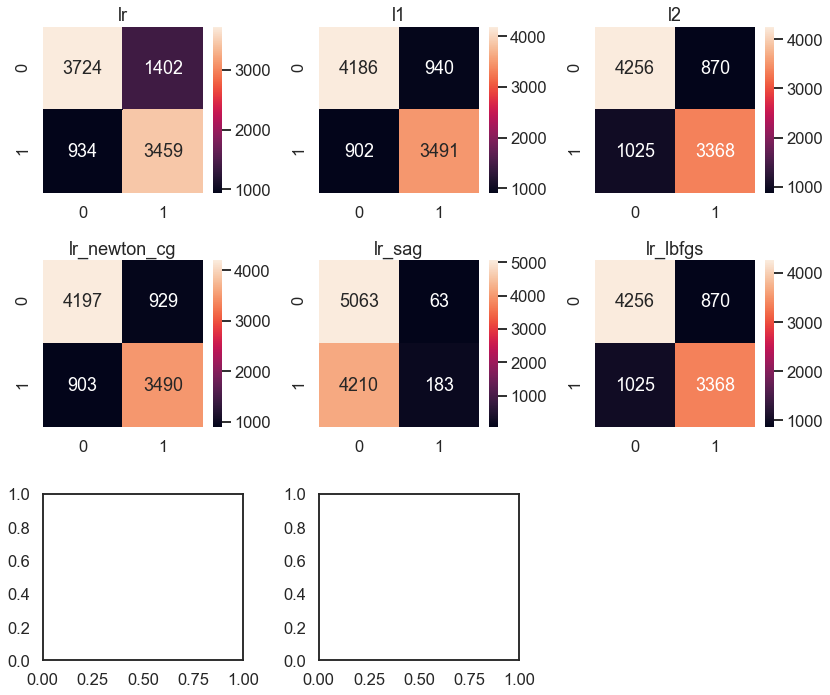

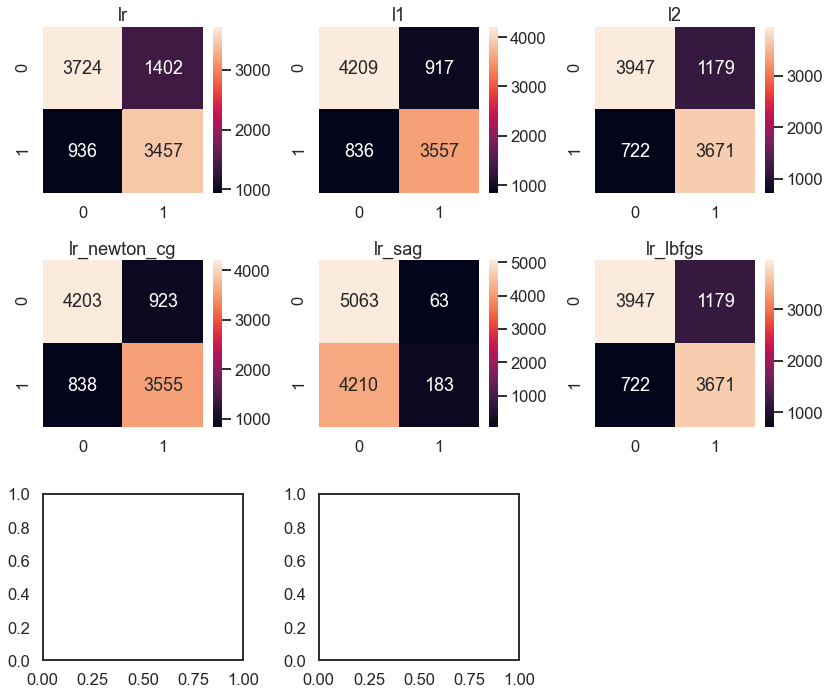

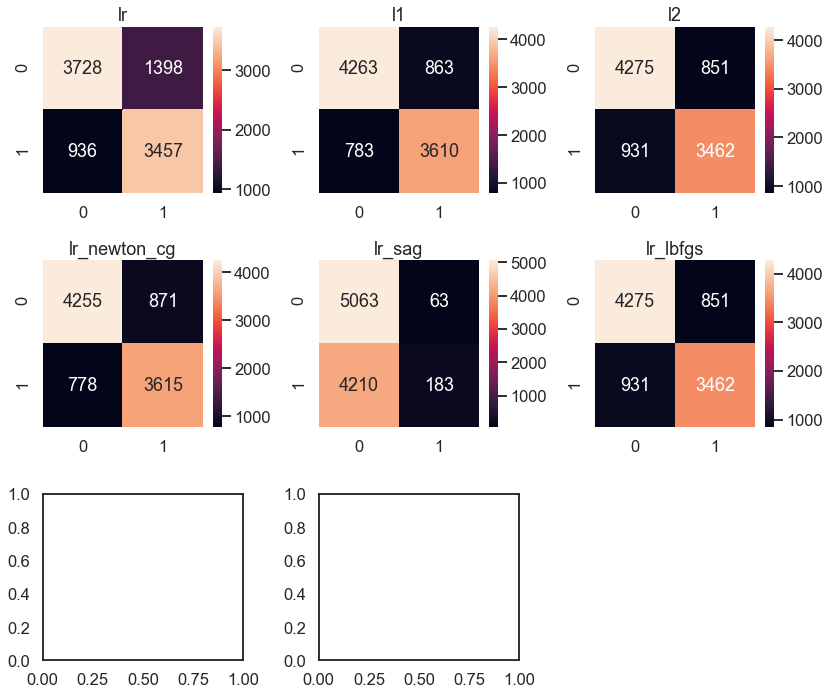

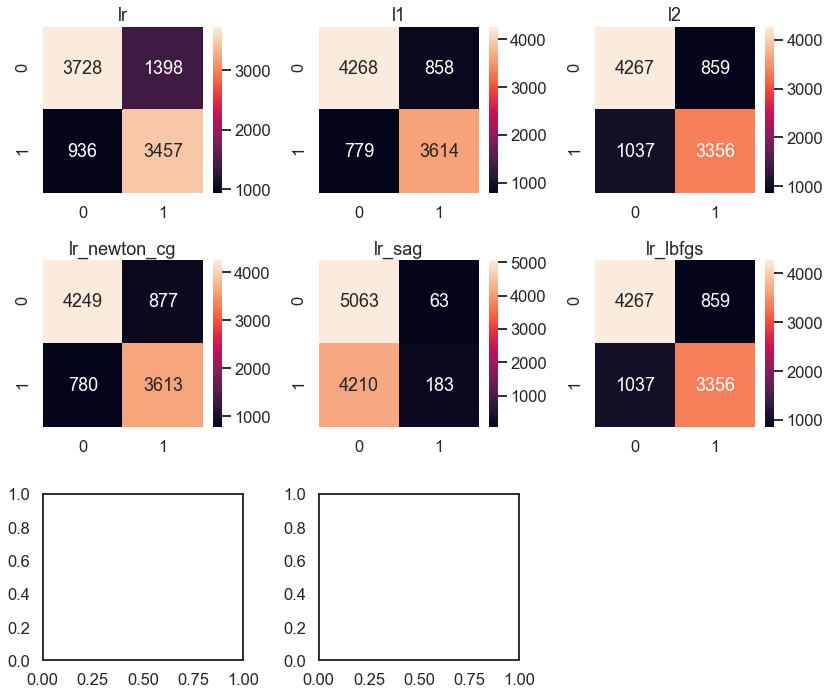

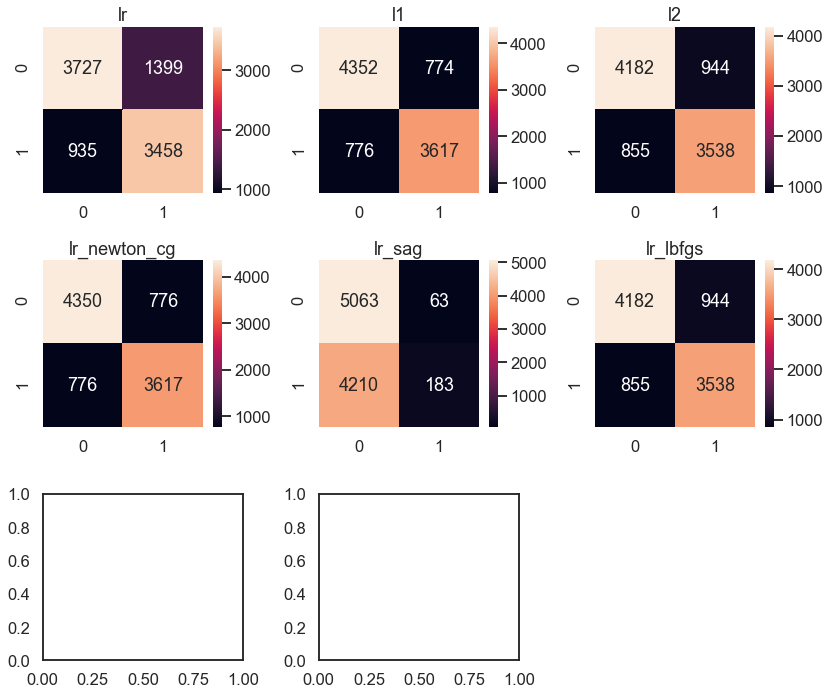

In [9]:
import time
list_run = ['finalDf-43.csv','finalDf-63.csv','finalDf-88.csv','finalDf-89.csv','finalDf-102.csv']
times = []
f = open('times.txt', 'a') 
for csv in list_run:
    start = time.time()
    run_csv(csv)
    end = time.time()
    f.write("{}:{}\n".format(csv ,(end - start)))
f.close()